# DF CON VARIABLES DE 4 HORAS #

In [315]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,root_mean_squared_error
import time


In [3]:
import requests

url = "https://api.binance.com/api/v3/exchangeInfo"
data = requests.get(url).json()

# Extraer todos los símbolos disponibles
symbols = [s['symbol'] for s in data['symbols']]
print(symbols[:20])  # mostrar los primeros 20

['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH', 'EOSETH', 'SNTETH', 'BNTETH', 'BCCBTC', 'GASBTC', 'BNBETH', 'BTCUSDT', 'ETHUSDT', 'HSRBTC', 'OAXETH', 'DNTETH', 'MCOETH', 'ICNETH', 'MCOBTC', 'WTCBTC']


In [42]:
def get_binance_ohlcv(symbol, interval="1d", days=6000):
    """
    Descarga velas OHLCV desde Binance.
    symbol: par de trading (ej: BTCUSDT)
    interval: intervalo de vela (ej: 1h, 1d, 15m)
    days: días de datos hacia atrás
    """
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Binance limita 1000 velas por request → dividir en chunks
    limit = 1000
    ms_interval = 60 * 60 * 1000  # 1h en milisegundos
    if interval == "1d":
        ms_interval = 24 * 60 * 60 * 1000
    
    end_time = int(time.time() * 1000)  # ahora en ms
    start_time = end_time - days * 24 * 60 * 60 * 1000
    
    all_data = []
    
    while start_time < end_time:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "limit": limit
        }
        resp = requests.get(base_url, params=params)
        data = resp.json()
        
        if not data:
            break
        
        all_data.extend(data)
        
        # avanzar el start_time al último timestamp + intervalo
        last_open_time = data[-1][0]
        start_time = last_open_time + ms_interval
        
        time.sleep(0.2)  # para no sobrecargar la API
    
    # convertir a DataFrame
    df = pd.DataFrame(all_data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    
    # limpiar tipos de datos
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = df[col].astype(float)
    
    return df[["open_time", "open", "high", "low", "close", "volume","number_of_trades"]]

In [43]:
df=get_binance_ohlcv("BTCUSDT")

In [44]:
df

,open_time,open,high,low,close,volume,number_of_trades
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,3427
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,5233
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2153
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2321
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,3972
...,...,...,...,...,...,...,...
2966,2025-09-30,114311.97,114792.00,112656.27,114048.93,15044.156330,3018331
2967,2025-10-01,114048.94,118649.10,113966.67,118594.99,20036.395160,3430343
2968,2025-10-02,118594.99,121022.07,118279.31,120529.35,19670.835030,3472073
2969,2025-10-03,120529.35,123894.99,119248.30,122232.00,23936.328000,4246820


In [45]:
#vamos a ver como funciona sin el volumen
df_porcentual=pd.DataFrame(columns=["4hora%","dia%","2dias%","1semana%"])
def porcentaje (df,columna_objetivo,n_de_intervalos,columna_nueva):

    for i in range(n_de_intervalos,len(df[columna_objetivo])):
        cambio=(df[columna_objetivo][i-n_de_intervalos]-df[columna_objetivo][i])/df[columna_objetivo][i-n_de_intervalos]
        df.loc[i,columna_nueva]=cambio*100
porcentaje(df,"close",1,"1dia%")
porcentaje(df,"close",2,"2dias%")
porcentaje(df,"close",7,"1semana%")
porcentaje(df,"close",14,"2semanas%")
porcentaje(df,"close",30,"1mes%")


#porcentaje(df,"close",1,"1hora%")
#porcentaje(df,"close",4,"4hora%")
#porcentaje(df,"close",8,"8hora%")
#porcentaje(df,"close",24,"dia%")
#porcentaje(df,"close",48,"2dias%")
#porcentaje(df,"close",24*7,"1semana%")
#porcentaje(df,"close",24*7*2,"2semanas%")
#porcentaje(df,"close",24*7*4,"1mes%")
#df.dropna(inplace=True)
#df.reset_index(drop=True,inplace=True)

In [46]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [47]:
df_porcentual=df

In [48]:
df_porcentual["pred_dia%"]=df_porcentual["1dia%"].shift(-1)
#df_porcentual["pred_dia%"]=df_porcentual["dia%"].shift(-24)

In [49]:

def calcular_RSI(df, column="close", period=21):
    """
    Calcula el RSI (Relative Strength Index) de un DataFrame.
    
    Parámetros:
        df: DataFrame con la columna de precios.
        column: columna sobre la cual calcular el RSI (por defecto 'close').
        period: ventana del RSI (por defecto 14).
        
    Retorna:
        DataFrame con una columna adicional 'RSI'.
    """
    # Calcular diferencias entre cierres
    delta = df[column].diff()

    # Separar ganancias y pérdidas
    ganancias = delta.clip(lower=0)
    perdidas = -delta.clip(upper=0)

    # Calcular medias móviles exponenciales
    media_gan = ganancias.ewm(span=period, adjust=False).mean()
    media_per = perdidas.ewm(span=period, adjust=False).mean()

    # Calcular RS y RSI
    RS = media_gan / media_per
    RSI = 100 - (100 / (1 + RS))

    df["RSI"] = RSI
    return df
calcular_RSI(df_porcentual)

,open_time,open,high,low,close,volume,number_of_trades,1dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI
0,2017-09-16,3674.01,3950.00,3470.66,3714.95,1297.563953,8809,-0.404054,-16.491900,12.770234,16.931268,13.305002,0.402697,NaN
1,2017-09-17,3685.23,3748.21,3499.02,3699.99,682.171210,6355,0.402697,0.000270,10.419890,17.943572,9.940195,-9.054619,0.000000
2,2017-09-18,3690.00,4123.20,3690.00,4035.01,1030.006455,8220,-9.054619,-8.615459,4.121688,1.587762,2.535519,3.097142,69.130453
3,2017-09-19,4060.00,4089.97,3830.91,3910.04,902.332129,7342,3.097142,-5.677042,6.092629,10.453066,4.313203,0.256775,53.854204
4,2017-09-20,3910.04,4046.08,3820.00,3900.00,720.935076,7231,0.256775,3.345964,1.132915,15.580213,2.888446,7.436154,52.822659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,2025-09-30,114311.97,114792.00,112656.27,114048.93,15044.156330,3018331,0.230098,-1.680558,-1.830493,2.346138,-5.360532,-3.986061,53.821501
2937,2025-10-01,114048.94,118649.10,113966.67,118594.99,20036.395160,3430343,-3.986061,-3.746791,-4.666958,-1.844091,-8.566268,-1.631064,66.146607
2938,2025-10-02,118594.99,121022.07,118279.31,120529.35,19670.835030,3472073,-1.631064,-5.682140,-10.582975,-2.951837,-8.350718,-1.412643,69.906060
2939,2025-10-03,120529.35,123894.99,119248.30,122232.00,23936.328000,4246820,-1.412643,-3.066748,-11.481341,-5.707415,-9.423234,-0.091367,72.827718


In [20]:
df_porcentual

,open_time,open,high,low,close,volume,1dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI
0,2017-09-16,3674.01,3950.00,3470.66,3714.95,1297.563953,-0.404054,-16.491900,12.770234,16.931268,13.305002,0.402697,NaN
1,2017-09-17,3685.23,3748.21,3499.02,3699.99,682.171210,0.402697,0.000270,10.419890,17.943572,9.940195,-9.054619,0.000000
2,2017-09-18,3690.00,4123.20,3690.00,4035.01,1030.006455,-9.054619,-8.615459,4.121688,1.587762,2.535519,3.097142,69.130453
3,2017-09-19,4060.00,4089.97,3830.91,3910.04,902.332129,3.097142,-5.677042,6.092629,10.453066,4.313203,0.256775,53.854204
4,2017-09-20,3910.04,4046.08,3820.00,3900.00,720.935076,0.256775,3.345964,1.132915,15.580213,2.888446,7.436154,52.822659
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,2025-09-30,114311.97,114792.00,112656.27,114048.93,15044.156330,0.230098,-1.680558,-1.830493,2.346138,-5.360532,-3.986061,53.821501
2937,2025-10-01,114048.94,118649.10,113966.67,118594.99,20036.395160,-3.986061,-3.746791,-4.666958,-1.844091,-8.566268,-1.631064,66.146607
2938,2025-10-02,118594.99,121022.07,118279.31,120529.35,19670.835030,-1.631064,-5.682140,-10.582975,-2.951837,-8.350718,-1.412643,69.906060
2939,2025-10-03,120529.35,123894.99,119248.30,122232.00,23936.328000,-1.412643,-3.066748,-11.481341,-5.707415,-9.423234,-0.178341,72.827718


In [50]:
def agregar_emas(df, column="close", spans=[9, 21, 50, 100,200]):

    for span in spans:
        df[f"EMA_{span}"] = df[column].ewm(span=span, adjust=False).mean()
    return df
agregar_emas(df_porcentual)

,open_time,open,high,low,close,volume,number_of_trades,1dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200
0,2017-09-16,3674.01,3950.00,3470.66,3714.95,1297.563953,8809,-0.404054,-16.491900,12.770234,16.931268,13.305002,0.402697,NaN,3714.950000,3714.950000,3714.950000,3714.950000,3714.950000
1,2017-09-17,3685.23,3748.21,3499.02,3699.99,682.171210,6355,0.402697,0.000270,10.419890,17.943572,9.940195,-9.054619,0.000000,3711.958000,3713.590000,3714.363333,3714.653762,3714.801144
2,2017-09-18,3690.00,4123.20,3690.00,4035.01,1030.006455,8220,-9.054619,-8.615459,4.121688,1.587762,2.535519,3.097142,69.130453,3776.568400,3742.810000,3726.937712,3720.997450,3717.987302
3,2017-09-19,4060.00,4089.97,3830.91,3910.04,902.332129,7342,3.097142,-5.677042,6.092629,10.453066,4.313203,0.256775,53.854204,3803.262720,3758.012727,3734.118194,3724.740867,3719.898274
4,2017-09-20,3910.04,4046.08,3820.00,3900.00,720.935076,7231,0.256775,3.345964,1.132915,15.580213,2.888446,7.436154,52.822659,3822.610176,3770.920661,3740.623363,3728.211345,3721.690331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,2025-09-30,114311.97,114792.00,112656.27,114048.93,15044.156330,3018331,0.230098,-1.680558,-1.830493,2.346138,-5.360532,-3.986061,53.821501,112728.689407,113094.573469,113362.607269,111844.631114,106415.536228
2937,2025-10-01,114048.94,118649.10,113966.67,118594.99,20036.395160,3430343,-3.986061,-3.746791,-4.666958,-1.844091,-8.566268,-1.631064,66.146607,113901.949526,113594.611336,113567.798749,111978.301587,106536.724822
2938,2025-10-02,118594.99,121022.07,118279.31,120529.35,19670.835030,3472073,-1.631064,-5.682140,-10.582975,-2.951837,-8.350718,-1.412643,69.906060,115227.429621,114225.042123,113840.800758,112147.629278,106675.954924
2939,2025-10-03,120529.35,123894.99,119248.30,122232.00,23936.328000,4246820,-1.412643,-3.066748,-11.481341,-5.707415,-9.423234,-0.091367,72.827718,116628.343697,114952.947385,114169.867395,112347.319787,106830.741442


In [78]:
df_porcentual

,open_time,open,high,low,close,volume,1dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200,resistencia
0,2017-09-16,3674.01,3950.00,3470.66,3714.95,1297.563953,-0.404054,-16.491900,12.770234,16.931268,13.305002,0.402697,39.364501,3907.513301,4117.424423,4223.084071,4256.206832,4271.115083,0
1,2017-09-17,3685.23,3748.21,3499.02,3699.99,682.171210,0.402697,0.000270,10.419890,17.943572,9.940195,-9.054619,38.986942,3866.008641,4079.475839,4202.570578,4245.192637,4265.432246,0
2,2017-09-18,3690.00,4123.20,3690.00,4035.01,1030.006455,-9.054619,-8.615459,4.121688,1.587762,2.535519,3.097142,51.104976,3899.808913,4075.433490,4195.999575,4241.030605,4263.139487,0
3,2017-09-19,4060.00,4089.97,3830.91,3910.04,902.332129,3.097142,-5.677042,6.092629,10.453066,4.313203,0.256775,47.080294,3901.855130,4060.397718,4184.785474,4234.476336,4259.626060,0
4,2017-09-20,3910.04,4046.08,3820.00,3900.00,720.935076,0.256775,3.345964,1.132915,15.580213,2.888446,7.436154,46.739082,3901.484104,4045.816107,4173.617416,4227.853042,4256.047691,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,2025-09-28,109635.85,112350.00,109189.99,112163.95,7542.331600,-2.305906,-2.298806,2.662743,2.692907,-3.493856,-1.915063,48.089594,111920.296574,112867.855598,113294.701610,111749.355173,106258.686629,0
2935,2025-09-29,112163.96,114400.00,111560.65,114311.96,15541.120050,-1.915063,-4.265129,-1.474439,0.899655,-5.050372,0.230098,58.375619,112398.629259,112999.137816,113334.594096,111800.099823,106338.818702,0
2936,2025-09-30,114311.97,114792.00,112656.27,114048.93,15044.156330,0.230098,-1.680558,-1.830493,2.346138,-5.360532,-3.986061,56.785792,112728.689407,113094.573469,113362.607269,111844.631114,106415.536228,0
2937,2025-10-01,114048.94,118649.10,113966.67,118594.99,20036.395160,-3.986061,-3.746791,-4.666958,-1.844091,-8.566268,-1.631064,71.995568,113901.949526,113594.611336,113567.798749,111978.301587,106536.724822,0


In [51]:
def volumen_por_precio(df, price_col="close", volume_col="volume", bins=50):
    """
    Calcula volumen por nivel de precio (Volume Profile).
    
    Parámetros:
        df: DataFrame con precios y volúmenes.
        price_col: columna de precios (por defecto 'close').
        volume_col: columna de volúmenes (por defecto 'volume').
        bins: número de intervalos de precio.
    
    Retorna:
        DataFrame con niveles de precio y volumen acumulado.
    """
    precios = df[price_col]
    volumenes = df[volume_col]

    # Crear bins de precio
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Calcular punto medio de cada bin
    price_levels = (edges[:-1] + edges[1:]) / 2

    vp = pd.DataFrame({"price_level": price_levels, "volume": hist})
    vp = vp.sort_values(by="volume", ascending=False).reset_index(drop=True)
    return vp
resistencias=volumen_por_precio(df_porcentual)

In [52]:
resistencias

,price_level,volume
0,21225.9265,2.015115e+07
1,23627.8207,1.920933e+07
2,9216.4555,1.805211e+07
3,18824.0323,1.777361e+07
4,6814.5613,1.463762e+07
5,16422.1381,1.444747e+07
6,11618.3497,7.923594e+06
7,4412.6671,7.690909e+06
8,28431.6091,7.362535e+06
9,35637.2917,4.491648e+06


In [53]:
#agregamos precios de resistencias
#vamos a poner 1 en cada zona de resistencia y 0 en donde no hay resistencias de volumen 
resis=[]
df_porcentual["resistencia"]=0
lista_redondeada_high = [round(x, 0) for x in list(df_porcentual["high"])]
lista_redondeada_low = [round(x, 0) for x in list(df_porcentual["low"])]
lista_redondeada_close = [round(x, 0) for x in list(df_porcentual["close"])]
for i in list(round(resistencias["price_level"],0)):
    if i in lista_redondeada_high:

        indice=lista_redondeada_high.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_low:

        indice=lista_redondeada_low.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_close:

        indice=lista_redondeada_close.index(i)
        df_porcentual.loc[indice,"resistencia"]=1

In [54]:
df_porcentual.dropna(inplace=True)
df_porcentual.reset_index(drop=True,inplace=True)

In [327]:
df_porcentual.columns

Index(['level_0', 'index', 'open_time', 'open', 'high', 'low', 'close',
       'volume', 'number_of_trades', '1dia%', '2dias%', '1semana%',
       '2semanas%', '1mes%', 'pred_dia%', 'RSI', 'EMA_9', 'EMA_21', 'EMA_50',
       'EMA_100', 'EMA_200', 'resistencia', 'resistencia_precio',
       'distancia_resistencia_%', 'distancia_resistencia_%_grande',
       'fuerza_resistencia_grande', 'distancia_resistencia_%_media',
       'fuerza_resistencia_media', 'distancia_resistencia_%_chica',
       'fuerza_resistencia_chica', 'direccion_pred'],
      dtype='object')

In [55]:
len(df_porcentual)

2939

In [372]:
relativ_error=[]
corr_direccion=0
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=[
    'level_0', 'index', 'open_time',   # índices y tiempo
    'pred_dia%', 'direccion_pred',     # información futura / etiquetas
    'resistencia',                     # categórica sin codificar
    'distancia_resistencia_%_grande', 
    'distancia_resistencia_%_media', 
    'distancia_resistencia_%_chica',   # redundantes
    'fuerza_resistencia_grande', 
    'fuerza_resistencia_media', 
    'fuerza_resistencia_chica'         # redundantes
]
medir='direccion_pred'
for i in range(50):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[0+i:2838+i]
    outsider=df_porcentual[2838+i+1:2838+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.2, random_state=42)
    #model=RandomForestRegressor( n_estimators=100, random_state=42)
    model=RandomForestClassifier( n_estimators=100, random_state=42)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])
    #error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
    relativ_error.append(error_relativo_porcentual)
    #if y_outsider[0]*predicciones_outsider>0:
        #aciertos_direccion_list.append(predicciones_outsider)
        #error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        #error_aciertos_list.append(error_relativo_aciertos)

#error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
#aciertos_direccion=len(aciertos_direccion_list)
#error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)

    if predicciones_outsider[0]==y_outsider[0]:
        corr_direccion+=1
print(corr_direccion/50)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.5


In [326]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')

error_aciertos: 0.0
n_aciertos: 0.48
error total: nan


error_aciertos: 0.10856790190498376
n_aciertos: 0.56
error total: 0.11244412090554494

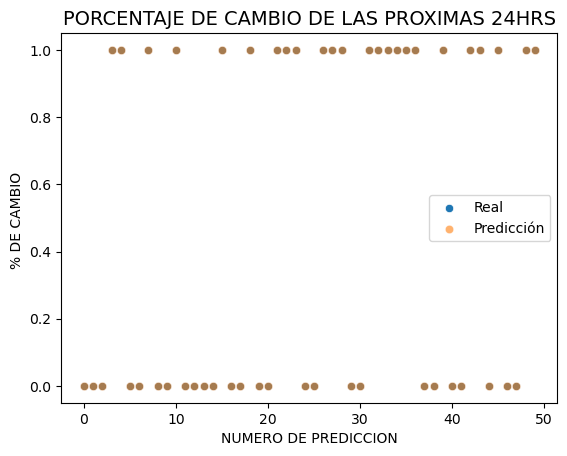

In [324]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
plt.title("PORCENTAJE DE CAMBIO DE LAS PROXIMAS 24HRS", fontsize=14)
plt.ylabel("% DE CAMBIO ")
plt.xlabel("NUMERO DE PREDICCION")

sns.scatterplot(guardados,x=guardados.index,y=guardados["real"],label="Real")
sns.scatterplot(guardados,x=guardados.index,y="predicciones",label="Predicción",alpha=0.6)
plt.legend()

In [25]:
#hay que traducir a precio
#predio anterior-precio nuevo/precio anterior
#%*precioanterior--precioanterior
precios=[]
comparacion=pd.DataFrame(columns=["real","prediccion"])
rev=df_porcentual["close"].tail(len(guardados["predicciones"]))
rev.dropna(inplace=True)
rev.reset_index(drop=True,inplace=True)
for i in range(len(guardados["predicciones"])):
    precio=(rev[i])-((abs(guardados["predicciones"][i])/100)*(rev[i]))
    print(precio)
    precios.append(precio)
comparacion["real"]=rev
comparacion["prediccion"]=precios


108652.05649918457
108623.84035025992
108565.617978208
108556.61915596946
108688.21073022288
109213.56485095747
109385.47936513659
109269.53359773687
108546.74588996585
108354.1146542709


In [17]:
#crear DF completo y modelo  guardarlo todo para mañana 

import requests
import pandas as pd
import time
import joblib

cripto=[]
accuracy=[]
error_acertados=[]
e_total=[]
contador=0



binance_coins = [
    "ETHUSDT",  # Ethereum
    "BTCUSDT",  # Bitcoin  
    "BNBUSDT",  # Binance Coin
    "XRPUSDT",  # Ripple
    "SOLUSDT",  # Solana
    "ADAUSDT",  # Cardano
    "LTCUSDT",  # Litecoin
    "DOTUSDT",  # Polkadot
    "AVAXUSDT", # Avalanche
    "LINKUSDT", # Chainlink
]
# guardar en CSV
for simbolo in binance_coins:
    print(simbolo)
    df=get_binance_ohlcv(simbolo)
    
    porcentaje(df,"close",1,"1hora%")
    porcentaje(df,"close",4,"4hora%")
    porcentaje(df,"close",8,"8hora%")
    porcentaje(df,"close",24,"dia%")
    porcentaje(df,"close",48,"2dias%")
    porcentaje(df,"close",24*7,"1semana%")
    porcentaje(df,"close",24*7*2,"2semanas%")
    porcentaje(df,"close",24*7*4,"1mes%")
    


    df_porcentual=df
    calcular_RSI(df_porcentual)
    agregar_emas(df_porcentual)

    resistencias=volumen_por_precio(df_porcentual)
    df_porcentual["pred_dia%"]=df_porcentual["dia%"].shift(-24)
    #df.dropna(inplace=True)
    #df.reset_index(drop=True,inplace=True)
    print(len(df_porcentual))
    resis=[]
    df_porcentual["resistencia"]=0
    lista_redondeada_high = [round(x, 0) for x in list(df_porcentual["high"])]
    lista_redondeada_low = [round(x, 0) for x in list(df_porcentual["low"])]
    lista_redondeada_close = [round(x, 0) for x in list(df_porcentual["close"])]
    for i in list(round(resistencias["price_level"],0)):
        if i in lista_redondeada_high:

            indice=lista_redondeada_high.index(i)
            df_porcentual.loc[indice,"resistencia"]=1
        elif i in lista_redondeada_low:

            indice=lista_redondeada_low.index(i)
            df_porcentual.loc[indice,"resistencia"]=1
        elif i in lista_redondeada_close:

            indice=lista_redondeada_close.index(i)
            df_porcentual.loc[indice,"resistencia"]=1


    df_porcentual.dropna(inplace=True)
    df_porcentual.reset_index(drop=True,inplace=True)
    print(len(df_porcentual))
    df_porcentual.to_csv("/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/data/raw/df_cripto/"+str(simbolo)+"_1h_250days_porcentual.csv", index=False)
    print("se tuvo que guardar")
    relativ_error=[]
    aciertos_direccion_list=[]
    error_aciertos_list=[]
    y_pred_guardadas=[]
    y_real_guardadas=[]
    restricciones=["open_time","pred_dia%"]
    medir="pred_dia%"
    print("empieza a modelo n: "+str(contador))
    filas=len(df_porcentual["close"])
    for i in range(120):
        if i%10==0:
            print(i)
        #vamos a separar los datos de entreno y los outsider
        entreno=df_porcentual[0+i:5183+i]
        outsider=df_porcentual[5183+i+1:5183+i+2]
        #print(outsider)
        outsider.reset_index(drop=True,inplace=True)
        entreno.reset_index(drop=True,inplace=True)
        #ahora ponemos el y el x
        X_entreno=entreno.drop(restricciones,axis=1)
        y=entreno[medir]
        X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
        model=RandomForestRegressor( n_estimators=50, random_state=42)
        model.fit(X_train,y_train)
        X_outsider=outsider.drop(restricciones,axis=1)
        y_outsider=outsider[medir]#es el real
        predicciones_outsider=model.predict(X_outsider)
        #print(y_outsider[0])
        y_pred_guardadas.append(predicciones_outsider[0])
        y_real_guardadas.append(y_outsider[0])
        error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        relativ_error.append(error_relativo_porcentual)
        if y_outsider[0]*predicciones_outsider>0:
            aciertos_direccion_list.append(predicciones_outsider)
            error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
            error_aciertos_list.append(error_relativo_aciertos)

    error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
    aciertos_direccion=len(aciertos_direccion_list)
    error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)
    contador+=1
    
    cripto.append(simbolo)
    accuracy.append(aciertos_direccion/len(relativ_error))
    error_acertados.append(error_aciertos)
    e_total.append(error_total)
    print(accuracy)
    

# Supón que tu modelo se llama 'model'
    joblib.dump(model,"/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/models/rand_forest_rf_"+str(simbolo)+".pkl")

ETHUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 0
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333]
BTCUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 1
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667]
BNBUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 2
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.875]
XRPUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 3
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.875, 0.85]
SOLUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 4
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.875, 0.85, 0.85]
ADAUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 5
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.875, 0.85, 0.85, 0.8]
LTCUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 6
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.816666666

KeyboardInterrupt: 

In [ ]:
binance_coins = [
    "ETHUSDT"
    ,"BTCUSDT",  # Bitcoin  # Ethereum
    "BNBUSDT",  # Binance Coin
    "XRPUSDT",  # Ripple
    "SOLUSDT",  # Solana
    "DOGEUSDT", # Dogecoin
    "ADAUSDT",  # Cardano
    "LTCUSDT",  # Litecoin
    "DOTUSDT",  # Polkadot
    "MATICUSDT",# Polygon
    "AVAXUSDT", # Avalanche
    "LINKUSDT", # Chainlink
    "TRXUSDT",  # Tron
    "ATOMUSDT", # Cosmos
    "SHIBUSDT", # Shiba Inu
    "WBTCUSDT", # Wrapped Bitcoin
    "BUSDUSDT", # Binance USD (stablecoin)
    "XLMUSDT"   # Stellar
]



In [241]:
from scipy.signal import find_peaks
def detectar_resistencias_por_picos(df, col_close='close', distancia=120, tolerancia=0.002):
    precios = df[col_close].values
    # find_peaks busca picos locales (máximos)
    indices, _ = find_peaks(precios, distance=distancia)

    resistencias = []

    for i in indices:
        precio_pico = precios[i]

        # Contamos cuántas veces el precio tocó esa zona ± tolerancia
        test_count = np.sum(
            np.abs(precios - precio_pico) / precio_pico < tolerancia
        )

        # Clasificamos la fuerza
        if test_count >= 5:
            fuerza = "fuerte"
        elif test_count >= 3:
            fuerza = "media"
        else:
            fuerza = "debil"

        resistencias.append({"precio": precio_pico, "fuerza": fuerza})

    resistencias_df = pd.DataFrame(resistencias).drop_duplicates(subset="precio").sort_values("precio")
    return resistencias_df.reset_index(drop=True)
res=detectar_resistencias_por_picos(df_porcentual)
res

,precio,fuerza
0,4117.76,debil
1,7359.06,fuerte
2,9864.00,media
3,10344.36,fuerte
4,11801.17,media
5,13093.80,debil
6,19102.66,fuerte
7,19695.87,debil
8,24441.38,media
9,24842.20,debil


In [273]:
def detectar_resistencias_por_picos(df, col_close='close', distancia=45, tolerancia=0.002):
    """
    Detecta picos locales (máximos) y clasifica fuerza según cuántas veces se testearon.
    distancia: min número de muestras entre picos (reduce detección de picos muy cercanos)
    tolerancia: % relativo para contar "toques" alrededor del pico (ej 0.002 = 0.2%)
    """
    # Asegurarnos que la columna es numérica y sin NaNs temporales
    precios = pd.to_numeric(df[col_close], errors='coerce').fillna(method='ffill').values.astype(float)

    # find_peaks devuelve índices de máximos locales
    indices, _ = find_peaks(precios, distance=distancia)

    resistencias = []
    for i in indices:
        precio_pico = float(precios[i])

        # contar cuántas veces el precio estuvo dentro de ±tolerancia relativa
        test_count = np.sum(np.abs(precios - precio_pico) / precio_pico < tolerancia)

        # clasificar fuerza por cantidad de toques (ajusta umbrales si quieres)
        if test_count >= 5:
            fuerza = "fuerte"
        elif test_count >= 3:
            fuerza = "media"
        else:
            fuerza = "debil"

        resistencias.append({"precio": precio_pico, "fuerza": fuerza, "toques": int(test_count)})

    res_df = pd.DataFrame(resistencias).drop_duplicates(subset="precio").sort_values("precio").reset_index(drop=True)
    return res_df


def asignar_resistencia(df, resistencias, col_close='close'):
    """
    Para cada fila de df:
      - asigna la resistencia MÁS CERCANA POR ENCIMA (si existe)
      - calcula distancia relativa en % (res - precio)/precio * 100
      - deja fuerza de la resistencia
    Maneja correctamente casos sin resistencia (produce NaN).
    """
    # Asegurarse tipos
    precios_res = resistencias['precio'].values.astype(float) if not resistencias.empty else np.array([], dtype=float)
    fuerzas_res = resistencias['fuerza'].values if not resistencias.empty else np.array([], dtype=object)

    resistencia_cercana = []
    distancia_res_pct = []
    fuerza_resistencia = []

    for p_raw in df[col_close].values:
        # si el precio es NaN, devolver NaNs
        try:
            p = float(p_raw)
        except Exception:
            resistencia_cercana.append(np.nan)
            distancia_res_pct.append(np.nan)
            fuerza_resistencia.append(None)
            continue

        if precios_res.size == 0:
            resistencia_cercana.append(np.nan)
            distancia_res_pct.append(np.nan)
            fuerza_resistencia.append(None)
            continue

        # elegir solo resistencias por encima del precio actual
        superiores = precios_res[precios_res > p]
        if superiores.size == 0:
            # no hay resistencia por encima
            resistencia_cercana.append(np.nan)
            distancia_res_pct.append(np.nan)
            fuerza_resistencia.append(None)
            continue

        # resistencia más cercana por encima
        res_mas_cercana = float(superiores.min())
        # índice robusto (en caso de problemas de float equality)
        idx = int(np.argmin(np.abs(precios_res - res_mas_cercana)))

        fuerza = fuerzas_res[idx]
        distancia = (res_mas_cercana - p) / p * 100.0  # en porcentaje

        resistencia_cercana.append(res_mas_cercana)
        distancia_res_pct.append(distancia)
        fuerza_resistencia.append(fuerza)

    # Asignar columnas al df sin romper por None
    df = df.copy()
    df['resistencia_precio'] = pd.Series(resistencia_cercana, index=df.index).astype(float)
    df['distancia_resistencia_%_media'] = pd.Series(distancia_res_pct, index=df.index).astype(float).round(3)
    df['fuerza_resistencia_media'] = pd.Series(fuerza_resistencia, index=df.index).astype(object)

    return df
res = detectar_resistencias_por_picos(df_porcentual, col_close='close', distancia=45, tolerancia=0.005)
df_porcentual = asignar_resistencia(df_porcentual.reset_index(), res, col_close='close')

/tmp/ipykernel_6159/3058702461.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precios = pd.to_numeric(df[col_close], errors='coerce').fillna(method='ffill').values.astype(float)


In [274]:
df_porcentual["fuerza_resistencia_media"]=df_porcentual["fuerza_resistencia"].factorize()[0]

In [298]:
df_porcentual

,level_0,index,open_time,open,high,low,close,volume,number_of_trades,1dia%,...,EMA_200,resistencia,resistencia_precio,distancia_resistencia_%,distancia_resistencia_%_grande,fuerza_resistencia_grande,distancia_resistencia_%_media,fuerza_resistencia_media,distancia_resistencia_%_chica,fuerza_resistencia_chica
0,0,0,2017-09-17,3685.23,3748.21,3499.02,3699.99,682.171210,6355,0.402697,...,3714.801144,0,4117.76,11.291,11.291,0,11.291,0,11.291,0
1,1,1,2017-09-18,3690.00,4123.20,3690.00,4035.01,1030.006455,8220,-9.054619,...,3717.987302,0,4117.76,2.051,2.051,0,2.051,0,2.051,0
2,2,2,2017-09-19,4060.00,4089.97,3830.91,3910.04,902.332129,7342,3.097142,...,3719.898274,0,4117.76,5.312,5.312,0,5.312,0,5.312,0
3,3,3,2017-09-20,3910.04,4046.08,3820.00,3900.00,720.935076,7231,0.256775,...,3721.690331,0,4117.76,5.584,5.584,0,5.584,0,5.584,0
4,4,4,2017-09-21,3889.99,3910.00,3567.00,3609.99,1001.654084,8714,7.436154,...,3720.578885,0,4117.76,14.066,14.066,0,14.066,0,14.066,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,2934,2934,2025-09-29,112163.96,114400.00,111560.65,114311.96,15541.120050,2442653,-1.915063,...,106338.818702,0,123306.43,7.868,7.868,2,7.868,2,7.868,2
2935,2935,2935,2025-09-30,114311.97,114792.00,112656.27,114048.93,15044.156330,3018331,0.230098,...,106415.536228,0,114311.96,8.117,8.117,2,0.231,2,8.117,2
2936,2936,2936,2025-10-01,114048.94,118649.10,113966.67,118594.99,20036.395160,3430343,-3.986061,...,106536.724822,0,123306.43,3.973,3.973,2,3.973,2,3.973,2
2937,2937,2937,2025-10-02,118594.99,121022.07,118279.31,120529.35,19670.835030,3472073,-1.631064,...,106675.954924,0,123306.43,2.304,2.304,2,2.304,2,2.304,2


# XGBoots #

In [333]:
from xgboost import XGBRegressor,XGBClassifier
from sklearn.model_selection import GridSearchCV

In [367]:
df_porcentual

,level_0,index,open_time,open,high,low,close,volume,number_of_trades,1dia%,...,resistencia,resistencia_precio,distancia_resistencia_%,distancia_resistencia_%_grande,fuerza_resistencia_grande,distancia_resistencia_%_media,fuerza_resistencia_media,distancia_resistencia_%_chica,fuerza_resistencia_chica,direccion_pred
0,0,0,2017-09-17,3685.23,3748.21,3499.02,3699.99,682.171210,6355,0.402697,...,0,4117.76,11.291,11.291,0,11.291,0,11.291,0,0
1,1,1,2017-09-18,3690.00,4123.20,3690.00,4035.01,1030.006455,8220,-9.054619,...,0,4117.76,2.051,2.051,0,2.051,0,2.051,0,1
2,2,2,2017-09-19,4060.00,4089.97,3830.91,3910.04,902.332129,7342,3.097142,...,0,4117.76,5.312,5.312,0,5.312,0,5.312,0,1
3,3,3,2017-09-20,3910.04,4046.08,3820.00,3900.00,720.935076,7231,0.256775,...,0,4117.76,5.584,5.584,0,5.584,0,5.584,0,1
4,4,4,2017-09-21,3889.99,3910.00,3567.00,3609.99,1001.654084,8714,7.436154,...,0,4117.76,14.066,14.066,0,14.066,0,14.066,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,2934,2934,2025-09-29,112163.96,114400.00,111560.65,114311.96,15541.120050,2442653,-1.915063,...,0,123306.43,7.868,7.868,2,7.868,2,7.868,2,1
2935,2935,2935,2025-09-30,114311.97,114792.00,112656.27,114048.93,15044.156330,3018331,0.230098,...,0,114311.96,8.117,8.117,2,0.231,2,8.117,2,0
2936,2936,2936,2025-10-01,114048.94,118649.10,113966.67,118594.99,20036.395160,3430343,-3.986061,...,0,123306.43,3.973,3.973,2,3.973,2,3.973,2,0
2937,2937,2937,2025-10-02,118594.99,121022.07,118279.31,120529.35,19670.835030,3472073,-1.631064,...,0,123306.43,2.304,2.304,2,2.304,2,2.304,2,0


In [377]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np

# modelo base
xgb = XGBClassifier(objective="binary:logistic", tree_method="hist",
                    random_state=42, n_jobs=-1, use_label_encoder=False, verbosity=0)

# parámetro (usa param_dist definido arriba)
param_dist = {
  "max_depth": [3,4,5,6,7],
  "min_child_weight": [1,3,5,7],
  "learning_rate": [0.01,0.03,0.05,0.08,0.1],
  "n_estimators": [200,500,800,1200],
  "subsample":[0.6,0.7,0.8,1.0],
  "colsample_bytree":[0.5,0.6,0.7,0.8],
  "gamma":[0,0.1,0.3,0.5],
  "reg_alpha":[0,0.01,0.1,1],
  "reg_lambda":[0.5,1,3,5]
}

tscv = TimeSeriesSplit(n_splits=5)

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring='roc_auc',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Nota: para usar early stopping en RandomizedSearch, lo mejor es dentro del fit de cada candidato
# pasar eval_set via fit_params. scikit-learn RandomizedSearch no pasa fit_params per split fácil.
# Alternativa: manual loop con xgb.train o usar skorch / Optuna. Aquí un simple fit (sin early stopping):
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best AUC:", rs.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.08, max_depth=6, min_child_weight=3, n_estimators=800, reg_alpha=1, reg_lambda=0.5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.01, reg_lambda=5, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.08, max_depth=6, min_child_weight=3, n_estimators=800, reg_alpha=1, reg_lambda=0.5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.08, max_depth=6, min_child_weight=3, n_estimators=800, reg_alpha=1, reg_lambda=0.5, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=7, n_estimators=500, reg_alpha=0.01, reg_lambda=5, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0

52.2

In [386]:
df_porcentual.columns

Index(['level_0', 'index', 'open_time', 'open', 'high', 'low', 'close',
       'volume', 'number_of_trades', '1dia%', '2dias%', '1semana%',
       '2semanas%', '1mes%', 'pred_dia%', 'RSI', 'EMA_9', 'EMA_21', 'EMA_50',
       'EMA_100', 'EMA_200', 'resistencia', 'resistencia_precio',
       'distancia_resistencia_%', 'distancia_resistencia_%_grande',
       'fuerza_resistencia_grande', 'distancia_resistencia_%_media',
       'fuerza_resistencia_media', 'distancia_resistencia_%_chica',
       'fuerza_resistencia_chica', 'direccion_pred'],
      dtype='object')

In [ ]:
corr_direccion=0
relativ_error=[]
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=['level_0', 'index', 'open_time', 'open', 'high', 'number_of_trades',
       '2semanas%',  'pred_dia%', 'EMA_21', 
       'EMA_100', 'resistencia', 'resistencia_precio',
       'distancia_resistencia_%', 'distancia_resistencia_%_grande',
       'fuerza_resistencia_grande', 'distancia_resistencia_%_media', 'distancia_resistencia_%_chica',
       'fuerza_resistencia_chica', 'direccion_pred']
##'low', 'close', 'volume', '1dia%', '2dias%', '1semana%', '1mes%', 'RSI', 'EMA_9', 'EMA_50', 'EMA_200', 'fuerza_resistencia_media']
medir='direccion_pred'
for i in range(100):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[0+i:2838+i]
    outsider=df_porcentual[2838+i+1:2838+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.2, random_state=42)
    #model=XGBRegressor(random_state=42,colsample_bytree=1, gamma= 0.5, learning_rate= 0.05 ,min_child_weight= 10, n_estimators= 500, reg_alpha= 0.01, reg_lambda= 0.5, subsample= 0.8)
    model=XGBClassifier(n_estimators= 377, max_depth= 3, learning_rate= 0.06253688500769382, subsample= 0.8993718943602277, colsample_bytree= 0.8571664280959813, min_child_weight= 3, gamma= 2.677408648496625,reg_lambda= 3.8577729312701874, reg_alpha= 0.5077544381282164)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])

    
    if predicciones_outsider[0]==y_outsider[0]:
        corr_direccion+=1
print(corr_direccion/100)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.55


Exception ignored in: <function ResourceTracker.__del__ at 0x760a11f8e8e0>
Traceback (most recent call last):
  File "/home/rodrigo/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/rodrigo/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/rodrigo/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7714b2d868e0>
Traceback (most recent call last):
  File "/home/rodrigo/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/rodrigo/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/rodrigo/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTrac

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

# 🔹 Lista de todas las features posibles que tienes en tu dataset
all_features = [
    'open', 'high', 'low', 'close', 'volume',
    '1dia%', '2dias%', '1semana%', '2semanas%', '1mes%',
    'RSI', 'EMA_9', 'EMA_21', 'EMA_50', 'EMA_100', 'EMA_200',
    'distancia_resistencia_%', 'fuerza_resistencia_media'
]

def objective(trial):
    # 🔸 El modelo que vamos a optimizar
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "gamma": trial.suggest_float("gamma", 0, 3),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "tree_method": "hist",
        "eval_metric": "auc",
        "random_state": 42
    }

    # 🔹 Aquí Optuna decide si usa cada feature o no (True/False)
    selected_features = [
        f for f in all_features if trial.suggest_categorical(f"use_{f}", [True, False])
    ]

    # Si por casualidad no elige ninguna, usa al menos algo
    if len(selected_features) == 0:
        selected_features = ["close", "volume"]

    X_sub = X_train[selected_features]

    tscv = TimeSeriesSplit(n_splits=5)
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_sub, y_train, cv=tscv, scoring="roc_auc", n_jobs=-1)

    return np.mean(scores)


# 🔸 Crear el estudio de búsqueda
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)  # puedes subir a 200 si tienes GPU o tiempo

# 🔹 Resultados
print("🏆 Mejor configuración encontrada:")
print(study.best_params)

# 🔹 Qué features eligió finalmente
selected_features = [f for f in all_features if study.best_params.get(f"use_" + f, False)]
print("\n📊 Features seleccionadas:")
print(selected_features)


[I 2025-10-04 16:53:38,137] A new study created in memory with name: no-name-7774cfe2-e3b5-4afa-af5e-343e418552e5
[I 2025-10-04 16:53:38,490] Trial 0 finished with value: 0.503670114779162 and parameters: {'n_estimators': 579, 'max_depth': 6, 'learning_rate': 0.0409403128892881, 'subsample': 0.6066502022296185, 'colsample_bytree': 0.860342964994318, 'min_child_weight': 8, 'gamma': 0.9786088169925599, 'reg_lambda': 2.703386906784044, 'reg_alpha': 0.9681070219295743, 'use_open': True, 'use_high': False, 'use_low': False, 'use_close': True, 'use_volume': False, 'use_1dia%': True, 'use_2dias%': True, 'use_1semana%': True, 'use_2semanas%': False, 'use_1mes%': True, 'use_RSI': False, 'use_EMA_9': False, 'use_EMA_21': True, 'use_EMA_50': True, 'use_EMA_100': True, 'use_EMA_200': False, 'use_distancia_resistencia_%': False, 'use_fuerza_resistencia_media': False}. Best is trial 0 with value: 0.503670114779162.
[I 2025-10-04 16:53:38,586] Trial 1 finished with value: 0.5157140325005944 and param

🏆 Mejor configuración encontrada:
{'n_estimators': 377, 'max_depth': 3, 'learning_rate': 0.06253688500769382, 'subsample': 0.8993718943602277, 'colsample_bytree': 0.8571664280959813, 'min_child_weight': 3, 'gamma': 2.677408648496625, 'reg_lambda': 3.8577729312701874, 'reg_alpha': 0.5077544381282164, 'use_open': False, 'use_high': False, 'use_low': True, 'use_close': True, 'use_volume': True, 'use_1dia%': True, 'use_2dias%': True, 'use_1semana%': True, 'use_2semanas%': False, 'use_1mes%': True, 'use_RSI': True, 'use_EMA_9': True, 'use_EMA_21': False, 'use_EMA_50': True, 'use_EMA_100': False, 'use_EMA_200': True, 'use_distancia_resistencia_%': False, 'use_fuerza_resistencia_media': True}

📊 Features seleccionadas:
['low', 'close', 'volume', '1dia%', '2dias%', '1semana%', '1mes%', 'RSI', 'EMA_9', 'EMA_50', 'EMA_200', 'fuerza_resistencia_media']


In [348]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')


error_aciertos: 0.0


ZeroDivisionError: division by zero

<Axes: xlabel='None', ylabel='real'>

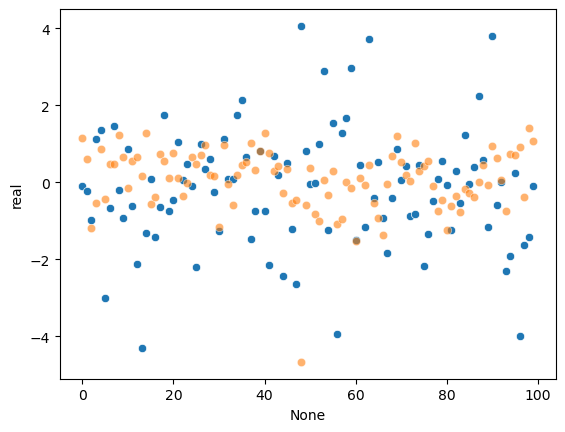

In [309]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
sns.scatterplot(guardados,x=guardados.index,y=guardados["real"])
sns.scatterplot(guardados,x=guardados.index,y="predicciones",alpha=0.6)

In [311]:
df_porcentual["direccion_pred"]=0
for i in range(len(df_porcentual["close"])):
    if df_porcentual["pred_dia%"][i]>0:
        df_porcentual.loc[i,"direccion_pred"]=1
    else:
        df_porcentual.loc[i,"direccion_pred"]=0
     

In [313]:
df_porcentual["pred_dia%"]

0      -9.054619
1       3.097142
2       0.256775
3       7.436154
4       0.391137
          ...   
2934    0.230098
2935   -3.986061
2936   -1.631064
2937   -1.412643
2938   -0.091367
Name: pred_dia%, Length: 2939, dtype: float64

In [105]:
def detectar_zonas_bajo_volumen(df, bins=80, n_zonas=150):
    """
    Calcula las zonas de bajo volumen (LVN) a partir de un perfil de volumen simple.

    bins: número de niveles de precios en el histograma
    n_zonas: cantidad de zonas de bajo volumen que quieres identificar
    """
    # Tomamos precio medio de cada vela
    df["precio_medio"] = (df["high"] + df["low"]) / 2
    precios = df["precio_medio"]
    volumenes = df["volume"]

    # Construir histograma ponderado por volumen
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Normalizamos
    hist = hist / hist.max()

    # Detectar los índices de menor volumen
    indices_lv = np.argsort(hist)[:n_zonas]
    zonas_bajo_volumen = [(edges[i], edges[i+1], hist[i]) for i in indices_lv]
   
    return zonas_bajo_volumen, hist, edges
zbv=detectar_zonas_bajo_volumen(df_porcentual)


In [106]:
#zonas de bajo volumen
df_porcentual["bajo_volumen"]=0
for i in zbv[0]:
    down=list(df_porcentual["close"].round(-3)).index(round(float(i[0]),-3))
    up=list(df_porcentual["close"].round(-3)).index(round(float(i[1]),-3))
    for o in range(1000):
        if df_porcentual["close"][o]==o:
            break
        elif df_porcentual["close"][o]!=o:
            df_porcentual.loc[o,"bajo_volumen"]=1

            






ValueError: 74000.0 is not in list

In [ ]:
#agregar las zonas de bajo volumen
for i in zbv[0]:
    for o in i:
        print(o)

368.34175000000005
371.57087500000006
0.0
365.1126250000001
368.34175000000005
0.0
342.5087500000001
345.73787500000003
0.021427931892905067
339.279625
342.5087500000001
0.02576023878280346
355.42525000000006
358.6543750000001
0.03869081730676724
361.8835
365.1126250000001
0.04046366988838033
119.699125
122.92825
0.055616995295260756
336.05050000000006
339.279625
0.06277751075950701
371.57087500000006
374.8
0.06433110183897132
358.6543750000001
361.8835
0.07327003818001582
345.73787500000003
348.96700000000004
0.08829675771830653
352.19612500000005
355.42525000000006
0.08864454585151317
348.96700000000004
352.19612500000005
0.11393790044654274
116.47
119.699125
0.1258172223606787
332.82137500000005
336.05050000000006
0.12996095364524937
155.2195
158.448625
0.13675905731590166
122.92825
126.157375
0.1494916480194506
151.990375
155.2195
0.15606293327294016
126.157375
129.3865
0.17280733975357737
239.17675000000003
242.40587500000004
0.1926511798808756
145.532125
148.76125000000002
0.2184

In [ ]:
import requests

url = "https://api.binance.com/api/v3/exchangeInfo"
data = requests.get(url).json()

# Extraer todos los símbolos disponibles
symbols = [s['symbol'] for s in data['symbols']]
print(symbols[:20])  # mostrar los primeros 20

['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH', 'EOSETH', 'SNTETH', 'BNTETH', 'BCCBTC', 'GASBTC', 'BNBETH', 'BTCUSDT', 'ETHUSDT', 'HSRBTC', 'OAXETH', 'DNTETH', 'MCOETH', 'ICNETH', 'MCOBTC', 'WTCBTC']
